# Deep dream algorithm: vizualizing what networks are learning

In this notebook, we will implement a version of the deep dream algorithm.

At the heart of these applications is the calculation of the gradient of a loss function with respect to the image itself (instead of respect to the weights).

Keras programming framework gives us the possibility to use a famous pretrained network : VGG16. There are useful predefined function which allow us to load the weights, view the architecture etc.

https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py

https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

First, let's load the necessary packages.

In [0]:
# Force the use of v1 tensorflow
%tensorflow_version 1.x
import tensorflow as tf

# Disabling warnings
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import vgg16
#from keras.applications import inception_v3
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


Let's load VGG16

In [0]:
# We set the learning phase to test, removing all operations linked to training
K.set_learning_phase(0)
# Loading vgg16 model without the last classification layer
model=vgg16.VGG16(weights='imagenet',include_top=False)

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

We will create a dictionary to get an easy reference to each layer.

In [0]:
layer_dict = dict([ (layer.name,layer) for layer in model.layers])

The idea of the Deep Dream algorithm is to find an image which maximises the response of a network at a certain layer.

This can be done by simply carrying out a gradient ascension.

Given an input image, we can iteratively add the gradient of the average of the weigths of one channel for a layer. As the model have already been trained, weights values and therefore activations in this layer correspond to the detection of certain features in the image. By doing this gradient ascension, we can modify the image to exacerbate the presence of theses features in the image. That could give us a hint of what a convolutionnal layer has learned to detect.


### Preprocesing image function
Let's first define a function to preprocess the image. This is needed to put the image in the correct format for the VGG16 network. We also create a function to invert this process.

In [0]:
def format_image(img_file=None):
    """
    This function reads and formats an image so that it can be fed to the VGG16 network
    
    Parameters
    ----------
    img_file : image file name
    
    Returns
    -------
    img_out_vgg : the correctly formatted image for VGG16
    img : the image as read by the load_img function of keras.preprocessing.image
    """
    # read image
    img = load_img(img_file)
    # convert image to an array
    img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16 network trained on imagenet
    img_out_vgg = vgg16.preprocess_input(img_out)
    # add a dimension at the beginning, coresponding to the batch dimension
    img_out_vgg = np.expand_dims(img_out_vgg, axis=0)
    return img_out_vgg, img

def unformat_image(img_in):
    """
    This function inverts the preprocessing applied to images for use in the VGG16 network
    
    Parameters
    ----------
    img_file : formatted image of shape (batch_size,m,n,3)
    
    Returns
    -------
    img_out : a m-by-n-by-3 array, representing an image that can be written to an image file
    """
    #get rid of batch dimension
    img_out=np.squeeze(img_in)
    #remove offsets added by the VGG16 preprocessing
    img_out[:, :, 0] += 103.939
    img_out[:, :, 1] += 116.779
    img_out[:, :, 2] += 123.68
    # invert the order of the colours : BGR -> RGB
    img_out = img_out[:, :, ::-1]
    #clamp image to the range [0,255] and cast to uint8
    img_out = np.clip(img_out, 0, 255).astype('uint8')
    return img_out

### Loading the image

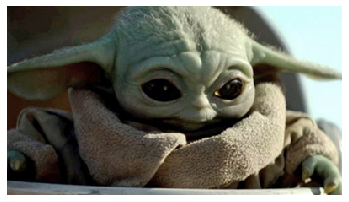

In [0]:
img_in,img_visu = format_image('images/baby_yoda.jpg')

#create a Tensor in the correct format for the network using the backend framework (Keras in this case)
img_backend = model.input

#show the input image
plt.imshow(img_visu)
plt.axis('off')
plt.show()

### Loss and gradient definition

We then define the loss that we want to maximise.
Here we will take the average weight response of the 42th channel of the 'block5_conv2' layer.

We then define the gradient of loss with respect to the image itself.
All of these operations are done using the keras backend, doing operations on symbolic tensors.

In [0]:
# Selection one layer from the model
layer_out = layer_dict['block5_conv2'].output

# Loss definition
loss = K.mean(layer_out[:,:,:,42])
# Gradient
grads = K.gradients(loss, img_backend)[0]
# Gradient normalization
grads_normalised = grads/ (K.maximum(K.mean(K.abs(grads)), K.epsilon()))

# Backend function to retrieve loss and gradient
get_loss_and_grads = K.function([img_backend],[loss,grads_normalised])

### Algorithm

............................................................

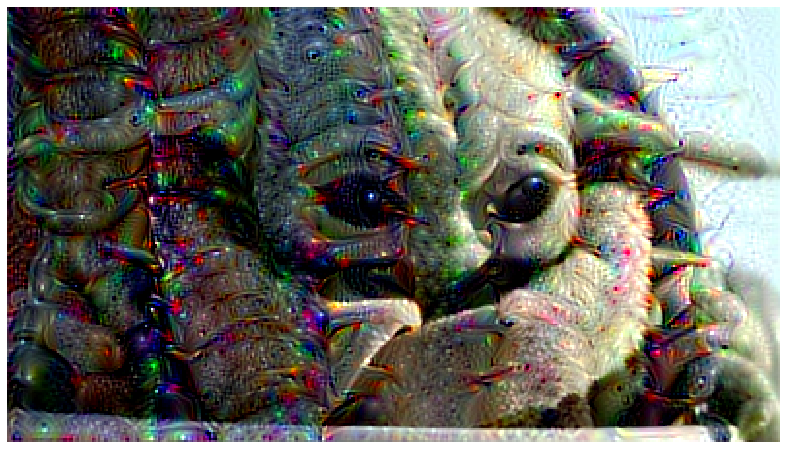

In [0]:
# Reloading the image, to start over
img_in,_ = format_image('images/baby_yoda.jpg')

step = 0.1 # Gradient ascent step size
n_iterations = 300
for i in range(0, n_iterations):
    loss_value,grads_value = get_loss_and_grads([img_in])
    img_in = img_in + grads_value * step
    if (i%5==0):
        print(".", end='')

img_out = unformat_image(np.copy(img_in))

plt.figure(figsize=(15,8))
plt.imshow(img_out)
plt.axis('off')
plt.imsave('img_out_'+'.png', img_out)
plt.show()

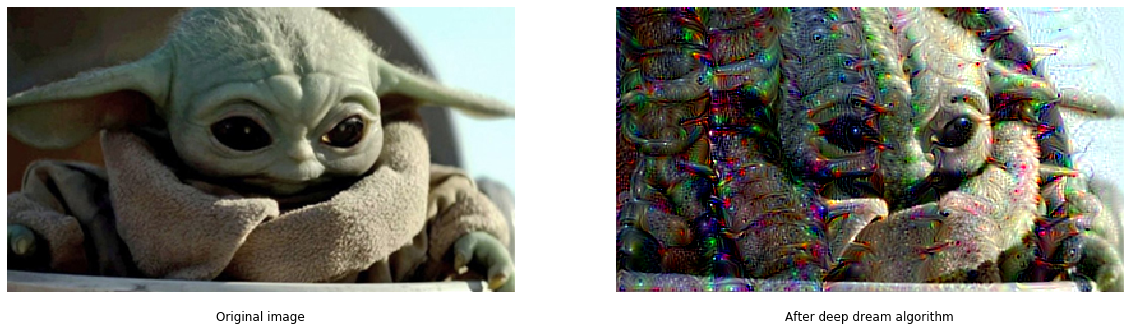

In [0]:
plt.figure(figsize=(20,12))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img_visu)
ax1.text(0.5,-0.1, "Original image", size=12, ha="center", 
         transform=ax1.transAxes)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(img_out)
ax2.text(0.5,-0.1, "After deep dream algorithm", size=12, ha="center", 
         transform=ax2.transAxes)

ax1.axis('off')
ax2.axis('off')
plt.show()

We could try different convolutional layers and see what the results are !